In [1]:
# AccraIQ: Municipal Transit Optimization System
# Ghana AI Hackathon 2025 - Transportation Challenge
# Advanced route optimization using DTW similarity, HDBSCAN clustering, and set cover optimization

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
import plotly.graph_objects as go
import zipfile
import os
import warnings
from sklearn.cluster import HDBSCAN
import pyproj
import json
from datetime import datetime
import time

warnings.filterwarnings("ignore")

# Required libraries
try:
    from dtw import dtw
    DTW_AVAILABLE = True
    print("✅ DTW library loaded")
except ImportError:
    DTW_AVAILABLE = False
    print("⚠️  DTW library not available")

try:
    import pulp as pl
    PULP_AVAILABLE = True
    print("✅ PuLP library loaded")
except ImportError:
    PULP_AVAILABLE = False
    print("⚠️  PuLP library not available")

print("🚀 AccraIQ: Municipal Transit Optimization System")
print("=" * 60)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

✅ DTW library loaded
✅ PuLP library loaded
🚀 AccraIQ: Municipal Transit Optimization System


In [2]:
# =============================================================================
# SECTION 1: GTFS DATA PROCESSING
# =============================================================================

def load_gtfs_data(gtfs_path="data/gtfs-accra-ghana-2016.zip"):
    """Load and process GTFS data for Accra transit network"""
    
    print(f"📊 Loading GTFS data from {gtfs_path}...")
    
    # Try multiple possible locations
    possible_paths = [
        gtfs_path,
        "data/gtfs-accra-ghana-2016.zip",
        "./gtfs-accra-ghana-2016.zip",
        "../data/gtfs-accra-ghana-2016.zip"
    ]
    
    found_path = None
    for path in possible_paths:
        if os.path.exists(path):
            found_path = path
            break
    
    if not found_path:
        raise FileNotFoundError("GTFS data file not found. Please ensure gtfs-accra-ghana-2016.zip is available.")
    
    try:
        with zipfile.ZipFile(found_path, 'r') as zip_file:
            data = {}
            gtfs_files = ['agency.txt', 'calendar.txt', 'routes.txt', 'stop_times.txt', 
                         'stops.txt', 'trips.txt', 'shapes.txt', 'fare_attributes.txt', 'fare_rules.txt']
            
            for file_name in gtfs_files:
                if file_name in zip_file.namelist():
                    with zip_file.open(file_name) as file:
                        df = pd.read_csv(file)
                        data[file_name.replace('.txt', '')] = df
                else:
                    data[file_name.replace('.txt', '')] = pd.DataFrame()
            
            print(f"✅ Loaded {len(data['routes'])} routes and {len(data['stops'])} stops")
            return data
            
    except Exception as e:
        raise Exception(f"Error loading GTFS file: {e}")

def classify_route_type(coords, length_km, straightness_ratio):
    """Classify route based on geometric characteristics"""
    
    if length_km < 5:
        return "short_local"
    elif length_km > 25:
        return "long_distance" if straightness_ratio > 0.6 else "meandering_long"
    elif straightness_ratio > 0.8:
        return "direct_connection"
    elif straightness_ratio < 0.3:
        return "circular_complex"
    else:
        return "standard_route"

def extract_route_geometries(gtfs_data):
    """Extract route geometries from GTFS shapes data"""
    
    print("🗺️  Extracting route geometries...")
    
    if gtfs_data['shapes'].empty:
        raise ValueError("No shapes data available")
    
    # Build route-to-shape mapping
    route_shape_map = {}
    route_info_map = {}
    
    if not gtfs_data['trips'].empty and not gtfs_data['routes'].empty:
        for _, route in gtfs_data['routes'].iterrows():
            route_info_map[route['route_id']] = {
                'route_short_name': route.get('route_short_name', route['route_id']),
                'route_long_name': route.get('route_long_name', f"Route {route['route_id']}"),
                'route_type': route.get('route_type', 3)
            }
        
        for _, trip in gtfs_data['trips'].iterrows():
            if 'shape_id' in trip and pd.notna(trip['shape_id']):
                route_shape_map[trip['route_id']] = trip['shape_id']
    
    route_geometries = []
    unique_shapes = gtfs_data['shapes']['shape_id'].unique()
    
    for shape_id in unique_shapes:
        shape_points = gtfs_data['shapes'][
            gtfs_data['shapes']['shape_id'] == shape_id
        ].sort_values('shape_pt_sequence')
        
        if len(shape_points) >= 2:
            coords = [(row['shape_pt_lon'], row['shape_pt_lat']) 
                     for _, row in shape_points.iterrows()]
            
            try:
                line = LineString(coords)
                
                # Find corresponding route
                route_id = None
                route_info = {}
                for r_id, s_id in route_shape_map.items():
                    if s_id == shape_id:
                        route_id = r_id
                        route_info = route_info_map.get(r_id, {})
                        break
                
                if route_id is None:
                    route_id = f"route_{shape_id}"
                    route_info = {
                        'route_short_name': route_id,
                        'route_long_name': f"Route {route_id}",
                        'route_type': 3
                    }
                
                # Calculate geometric metrics
                length_km = line.length * 111  # Approximate conversion to km
                start_point = Point(coords[0])
                end_point = Point(coords[-1])
                direct_distance = start_point.distance(end_point) * 111
                straightness_ratio = direct_distance / length_km if length_km > 0 else 0
                route_type_geo = classify_route_type(coords, length_km, straightness_ratio)
                
                route_geometries.append({
                    'route_id': route_id,
                    'shape_id': shape_id,
                    'route_short_name': route_info.get('route_short_name', route_id),
                    'route_long_name': route_info.get('route_long_name', f"Route {route_id}"),
                    'geometry': line,
                    'length_km': length_km,
                    'num_points': len(shape_points),
                    'straightness_ratio': straightness_ratio,
                    'point_density_per_km': len(shape_points) / length_km if length_km > 0 else 0,
                    'start_lat': coords[0][1],
                    'start_lon': coords[0][0],
                    'end_lat': coords[-1][1],
                    'end_lon': coords[-1][0],
                    'centroid_lat': line.centroid.y,
                    'centroid_lon': line.centroid.x,
                    'route_type_geo': route_type_geo
                })
                
            except Exception as e:
                continue
    
    route_gdf = gpd.GeoDataFrame(route_geometries, crs='EPSG:4326')
    
    print(f"✅ Processed {len(route_gdf)} routes")
    print(f"   Total network length: {route_gdf['length_km'].sum():.1f} km")
    print(f"   Average route length: {route_gdf['length_km'].mean():.2f} km")
    
    return route_gdf

In [3]:
# =============================================================================
# SECTION 2: ROUTE SIMILARITY ANALYSIS
# =============================================================================

class CoordinateNormalizer:
    """Normalize coordinates for consistent distance calculations"""
    
    def __init__(self, method="utm"):
        self.method = method
        self.transformer = pyproj.Transformer.from_crs(
            'EPSG:4326', 'EPSG:32630', always_xy=True  # UTM Zone 30N for Accra
        )
    
    def normalize(self, coords):
        """Convert coordinates to normalized form"""
        if self.method == "utm":
            normalized = []
            for lon, lat in coords:
                x, y = self.transformer.transform(lon, lat)
                normalized.append([x, y])
            return np.array(normalized)
        else:
            return np.array(coords)

class DTWAnalyzer:
    """Dynamic Time Warping analysis for route similarity"""
    
    def __init__(self, route_gdf, normalizer=None):
        self.route_gdf = route_gdf
        self.normalizer = normalizer or CoordinateNormalizer("utm")
        self.route_signatures = {}
        self.valid_route_indices = []
    
    def extract_route_signature(self, route_geometry, target_points=30):
        """Extract comprehensive route signature"""
        
        if route_geometry.geom_type != 'LineString':
            return None
        
        coords = list(route_geometry.coords)
        if len(coords) < 2:
            return None
        
        try:
            # Normalize coordinates
            normalized_coords = self.normalizer.normalize(coords)
            line = LineString(normalized_coords)
            
            # Interpolate to fixed number of points
            distances = np.linspace(0, line.length, target_points)
            interpolated_points = []
            
            for dist in distances:
                point = line.interpolate(dist)
                interpolated_points.append([point.x, point.y])
            
            interpolated_points = np.array(interpolated_points)
            
            # Calculate bearing sequence
            bearings = []
            for i in range(len(interpolated_points) - 1):
                dx = interpolated_points[i + 1, 0] - interpolated_points[i, 0]
                dy = interpolated_points[i + 1, 1] - interpolated_points[i, 1]
                bearing = np.arctan2(dy, dx)
                bearings.append(bearing)
            
            bearings = np.array(bearings)
            
            # Create bearing histogram (directional signature)
            bearing_hist, _ = np.histogram(bearings, bins=12, range=(-np.pi, np.pi))
            bearing_hist = bearing_hist / np.sum(bearing_hist) if np.sum(bearing_hist) > 0 else bearing_hist
            
            return {
                'coordinates': interpolated_points,
                'bearing_histogram': bearing_hist,
                'length_m': line.length,
                'start_bearing': bearings[0] if len(bearings) > 0 else 0,
                'end_bearing': bearings[-1] if len(bearings) > 0 else 0,
                'bearing_variance': np.var(bearings) if len(bearings) > 0 else 0,
                'start_point': interpolated_points[0],
                'end_point': interpolated_points[-1],
                'centroid': interpolated_points.mean(axis=0)
            }
            
        except Exception as e:
            return None
    
    def calculate_composite_distance(self, sig1, sig2, weights=(0.5, 0.3, 0.2)):
        """Calculate composite distance between route signatures"""
        
        w_dtw, w_bearing, w_spatial = weights
        
        # DTW distance on coordinates
        if DTW_AVAILABLE:
            try:
                alignment = dtw(sig1['coordinates'], sig2['coordinates'], distance_only=True)
                scale_factor = np.sqrt(max(sig1['length_m'], sig2['length_m']) / 1000)
                dtw_dist = alignment.distance / (len(sig1['coordinates']) * scale_factor)
            except:
                dtw_dist = np.linalg.norm(sig1['centroid'] - sig2['centroid']) / 1000
        else:
            dtw_dist = np.linalg.norm(sig1['centroid'] - sig2['centroid']) / 1000
        
        # Bearing similarity
        hist1, hist2 = sig1['bearing_histogram'], sig2['bearing_histogram']
        dot_product = np.dot(hist1, hist2)
        norm1, norm2 = np.linalg.norm(hist1), np.linalg.norm(hist2)
        
        if norm1 > 0 and norm2 > 0:
            bearing_similarity = dot_product / (norm1 * norm2)
            bearing_dist = 1 - bearing_similarity
        else:
            bearing_dist = 1.0
        
        # Spatial features
        length_ratio = min(sig1['length_m'], sig2['length_m']) / max(sig1['length_m'], sig2['length_m'])
        length_dist = 1 - length_ratio
        
        start_dist = np.linalg.norm(sig1['start_point'] - sig2['start_point']) / 1000
        end_dist = np.linalg.norm(sig1['end_point'] - sig2['end_point']) / 1000
        endpoint_dist = min((start_dist + end_dist) / 2, 10)
        
        spatial_dist = 0.5 * length_dist + 0.5 * (endpoint_dist / 10)
        
        # Combine distances
        composite_dist = w_dtw * dtw_dist + w_bearing * bearing_dist + w_spatial * spatial_dist
        
        return composite_dist
    
    def compute_similarity_matrix(self, target_density=8, sample_size=None):
        """Compute route similarity matrix"""
        
        n_routes = len(self.route_gdf) if sample_size is None else min(sample_size, len(self.route_gdf))
        print(f"🔄 Computing similarity matrix for {n_routes} routes...")
        
        # Extract route signatures
        signatures = {}
        valid_routes = []
        
        route_sample = self.route_gdf.head(n_routes) if sample_size else self.route_gdf
        
        for idx, route in route_sample.iterrows():
            sig = self.extract_route_signature(route['geometry'], target_points=target_density * 4)
            if sig is not None:
                signatures[idx] = sig
                valid_routes.append(idx)
        
        print(f"   Extracted {len(signatures)} signatures")
        
        # Compute distance matrix
        n_valid = len(valid_routes)
        distance_matrix = np.zeros((n_valid, n_valid))
        
        for i in range(n_valid):
            for j in range(i, n_valid):
                if i == j:
                    distance_matrix[i, j] = 0.0
                else:
                    idx1, idx2 = valid_routes[i], valid_routes[j]
                    dist = self.calculate_composite_distance(signatures[idx1], signatures[idx2])
                    distance_matrix[i, j] = dist
                    distance_matrix[j, i] = dist
        
        # Scale by median for better clustering
        distance_values = distance_matrix[distance_matrix > 0]
        if len(distance_values) > 0:
            scale_factor = np.median(distance_values)
            distance_matrix_scaled = distance_matrix / scale_factor
        else:
            distance_matrix_scaled = distance_matrix
        
        self.route_signatures = signatures
        self.valid_route_indices = valid_routes
        
        return distance_matrix_scaled


In [4]:
# =============================================================================
# SECTION 3: ROUTE CLUSTERING
# =============================================================================

def cluster_similar_routes(distance_matrix, route_indices, min_cluster_size=5, min_samples=5):
    """Cluster similar routes using HDBSCAN"""
    
    print(f"🔄 Clustering routes using HDBSCAN...")
    
    # Primary clustering with HDBSCAN leaf method
    clusterer = HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='precomputed',
        cluster_selection_method='leaf',
        allow_single_cluster=False
    )
    
    labels = clusterer.fit_predict(distance_matrix)
    
    n_clusters = len(set(labels[labels >= 0]))
    n_noise = np.sum(labels == -1)
    
    print(f"   Primary clustering: {n_clusters} clusters, {n_noise} noise points")
    
    # Secondary clustering for noise points
    final_labels = labels.copy()
    noise_indices = np.where(labels == -1)[0]
    
    if len(noise_indices) > 5:
        print(f"   Re-clustering {len(noise_indices)} noise points...")
        
        noise_sub_matrix = distance_matrix[np.ix_(noise_indices, noise_indices)]
        
        noise_clusterer = HDBSCAN(
            min_cluster_size=2,
            min_samples=1,
            metric='precomputed',
            cluster_selection_method='leaf',
            allow_single_cluster=False
        )
        
        try:
            noise_labels = noise_clusterer.fit_predict(noise_sub_matrix)
            n_micro_clusters = len(set(noise_labels[noise_labels >= 0]))
            remaining_noise = np.sum(noise_labels == -1)
            
            # Merge micro-clusters back
            next_label = n_clusters
            for i, noise_idx in enumerate(noise_indices):
                if noise_labels[i] >= 0:
                    final_labels[noise_idx] = next_label + noise_labels[i]
                else:
                    final_labels[noise_idx] = next_label + n_micro_clusters + (remaining_noise - np.sum(noise_labels[i:] == -1))
            
            total_real_clusters = n_clusters + n_micro_clusters
            total_singletons = remaining_noise
            
        except Exception:
            # Fallback: convert noise to singletons
            next_label = n_clusters
            for noise_idx in noise_indices:
                final_labels[noise_idx] = next_label
                next_label += 1
            total_real_clusters = n_clusters
            total_singletons = len(noise_indices)
    else:
        # Convert small noise to singletons
        next_label = n_clusters
        for noise_idx in noise_indices:
            final_labels[noise_idx] = next_label
            next_label += 1
        total_real_clusters = n_clusters
        total_singletons = len(noise_indices)
    
    total_clusters = len(set(final_labels))
    print(f"✅ Final clustering: {total_real_clusters} meaningful clusters + {total_singletons} singletons")
    
    return final_labels


In [5]:
# =============================================================================
# SECTION 4: SET COVER OPTIMIZATION
# =============================================================================

def optimize_route_selection(final_labels, route_indices, route_gdf, gtfs_data, coverage_threshold=0.92):
    """Optimize route selection using set cover formulation"""
    
    print(f"🔄 Optimizing route selection for {coverage_threshold * 100:.0f}% coverage...")
    
    if not PULP_AVAILABLE:
        return greedy_route_selection(final_labels, route_indices, route_gdf, gtfs_data, coverage_threshold)
    
    # Build route-to-stops mapping
    if gtfs_data['stop_times'].empty or gtfs_data['trips'].empty:
        print("❌ No stop_times or trips data available")
        return [], 0.0, 0
    
    route_to_stops = {}
    trips_df = gtfs_data['trips']
    stop_times_df = gtfs_data['stop_times']
    merged = pd.merge(trips_df[['route_id', 'trip_id']], stop_times_df[['trip_id', 'stop_id']], on='trip_id')
    
    for rid, group in merged.groupby('route_id'):
        route_to_stops[rid] = set(group['stop_id'].unique())
    
    all_stops = set(stop_times_df['stop_id'].unique())
    
    # Build cluster mapping
    clusters = {}
    for route_idx, cluster_label in enumerate(final_labels):
        if route_idx < len(route_indices):
            route_id = route_gdf.iloc[route_indices[route_idx]]['route_id']
            clusters.setdefault(cluster_label, []).append(route_id)
    
    # Get candidate routes
    all_candidate_routes = []
    routes_covering = {stop: [] for stop in all_stops}
    
    for cluster_routes in clusters.values():
        all_candidate_routes.extend(cluster_routes)
    
    for route_id in all_candidate_routes:
        if route_id in route_to_stops:
            for stop in route_to_stops[route_id]:
                routes_covering[stop].append(route_id)
    
    # Filter coverable stops
    coverable_stops = [stop for stop in all_stops if len(routes_covering[stop]) > 0]
    target_stops_count = int(len(coverable_stops) * coverage_threshold)
    
    print(f"   Target: {target_stops_count} out of {len(coverable_stops)} coverable stops")
    
    # Set up optimization problem
    x = {route: pl.LpVariable(f"x_{route}", 0, 1, pl.LpBinary) for route in all_candidate_routes}
    
    prob = pl.LpProblem("MinimalSetCover", pl.LpMinimize)
    prob += pl.lpSum(x.values())  # Minimize number of routes
    
    stop_coverage_vars = {}
    for stop in coverable_stops:
        stop_coverage_vars[stop] = pl.LpVariable(f"covered_{stop}", 0, 1, pl.LpBinary)
        if len(routes_covering[stop]) > 0:
            prob += stop_coverage_vars[stop] <= pl.lpSum(x[route] for route in routes_covering[stop])
    
    # Coverage constraint
    prob += pl.lpSum(stop_coverage_vars.values()) >= target_stops_count
    
    # Solve
    prob.solve(pl.PULP_CBC_CMD(msg=False))
    
    if prob.status == pl.LpStatusOptimal:
        selected_routes = [route for route, var in x.items() if var.value() == 1]
        
        # Calculate actual coverage
        covered_stops = set()
        for route in selected_routes:
            covered_stops.update(route_to_stops.get(route, set()))
        
        coverage_percent = len(covered_stops) / len(all_stops) * 100
        
        print(f"✅ Optimal solution: {len(selected_routes)} routes, {coverage_percent:.1f}% coverage")
        
        return selected_routes, coverage_percent, len(selected_routes)
    
    else:
        print("❌ Optimization failed, using greedy fallback")
        return greedy_route_selection(final_labels, route_indices, route_gdf, gtfs_data, coverage_threshold)

def greedy_route_selection(final_labels, route_indices, route_gdf, gtfs_data, coverage_threshold):
    """Greedy fallback for route selection"""
    
    # Build route-to-stops mapping
    route_to_stops = {}
    trips_df = gtfs_data['trips']
    stop_times_df = gtfs_data['stop_times']
    merged = pd.merge(trips_df[['route_id', 'trip_id']], stop_times_df[['trip_id', 'stop_id']], on='trip_id')
    
    for rid, group in merged.groupby('route_id'):
        route_to_stops[rid] = set(group['stop_id'].unique())
    
    all_stops = set(stop_times_df['stop_id'].unique())
    
    # Build cluster mapping
    clusters = {}
    for route_idx, cluster_label in enumerate(final_labels):
        if route_idx < len(route_indices):
            route_id = route_gdf.iloc[route_indices[route_idx]]['route_id']
            clusters.setdefault(cluster_label, []).append(route_id)
    
    # Start with best representative per cluster
    selected_routes = []
    for cluster_routes in clusters.values():
        if cluster_routes:
            best_route = max(cluster_routes, key=lambda rid: len(route_to_stops.get(rid, [])))
            selected_routes.append(best_route)
    
    # Greedy improvement
    covered_stops = set().union(*[route_to_stops.get(rid, set()) for rid in selected_routes])
    coverage_percent = len(covered_stops) / len(all_stops) * 100
    
    all_routes = [r for cluster_routes in clusters.values() for r in cluster_routes]
    remaining_routes = [r for r in all_routes if r not in selected_routes]
    
    while coverage_percent < coverage_threshold * 100 and remaining_routes:
        uncovered_stops = all_stops - covered_stops
        if not uncovered_stops:
            break
        
        best_route = max(remaining_routes, key=lambda r: len(route_to_stops.get(r, set()) & uncovered_stops))
        selected_routes.append(best_route)
        remaining_routes.remove(best_route)
        
        covered_stops |= route_to_stops.get(best_route, set())
        coverage_percent = len(covered_stops) / len(all_stops) * 100
    
    return selected_routes, coverage_percent, len(selected_routes)


In [6]:
# =============================================================================
# SECTION 5: IMPACT CALCULATION
# =============================================================================

class MunicipalImpactCalculator:
    """Calculate comprehensive municipal impact"""
    
    def __init__(self, route_gdf):
        self.route_gdf = route_gdf
        
        # Municipal parameters
        self.fuel_efficiency_l_per_km = 0.35
        self.co2_kg_per_liter = 2.68
        self.diesel_price_ghs_per_liter = 15.0
        self.usd_to_ghs = 3.2
        self.vehicle_cost_usd = 28000
        self.daily_trips_per_route = 8
        self.maintenance_cost_per_km_usd = 0.15
        self.driver_salary_per_route_usd = 3000
    
    def calculate_impact(self, final_labels, valid_indices, selected_routes, coverage_pct):
        """Calculate comprehensive municipal impact"""
        
        print("💰 Calculating municipal impact...")
        
        total_routes = len(valid_indices)
        retained_routes = len(selected_routes)
        eliminated_routes = total_routes - retained_routes
        
        # Length analysis
        total_original_length = self.route_gdf.loc[valid_indices]['length_km'].sum()
        selected_route_gdf = self.route_gdf[self.route_gdf['route_id'].isin(selected_routes)]
        retained_length = selected_route_gdf['length_km'].sum() if not selected_route_gdf.empty else 0
        eliminated_length_km = total_original_length - retained_length
        
        # Economic calculations
        daily_route_km_saved = eliminated_length_km * self.daily_trips_per_route
        daily_fuel_saved_l = daily_route_km_saved * self.fuel_efficiency_l_per_km
        annual_fuel_saved_l = daily_fuel_saved_l * 365
        annual_fuel_cost_saved_usd = (annual_fuel_saved_l * self.diesel_price_ghs_per_liter) / self.usd_to_ghs
        
        annual_maintenance_saved_usd = eliminated_length_km * 365 * self.daily_trips_per_route * self.maintenance_cost_per_km_usd
        annual_driver_savings_usd = eliminated_routes * self.driver_salary_per_route_usd
        total_annual_savings_usd = annual_fuel_cost_saved_usd + annual_maintenance_saved_usd + annual_driver_savings_usd
        
        # Environmental impact
        annual_co2_saved_tonnes = (annual_fuel_saved_l * self.co2_kg_per_liter) / 1000
        cars_equivalent_removed = annual_co2_saved_tonnes / 4.6
        
        # Cluster analysis
        cluster_analysis = []
        unique_clusters = np.unique(final_labels)
        valid_route_data = self.route_gdf.loc[valid_indices].copy()
        valid_route_data['cluster'] = final_labels
        
        for cluster_id in unique_clusters:
            cluster_routes = valid_route_data[valid_route_data['cluster'] == cluster_id]
            representatives = [r for r in selected_routes if r in cluster_routes['route_id'].values]
            
            cluster_analysis.append({
                'cluster_id': cluster_id,
                'n_routes': len(cluster_routes),
                'representatives_selected': len(representatives),
                'cluster_length_km': cluster_routes['length_km'].sum(),
                'avg_route_length': cluster_routes['length_km'].mean(),
                'reduction_in_cluster': 1 - (len(representatives) / len(cluster_routes)) if len(cluster_routes) > 0 else 0
            })
        
        return {
            'total_routes': total_routes,
            'retained_routes': retained_routes,
            'eliminated_routes': eliminated_routes,
            'route_reduction_pct': (eliminated_routes / total_routes) * 100,
            'total_length_km': total_original_length,
            'retained_length_km': retained_length,
            'eliminated_length_km': eliminated_length_km,
            'length_reduction_pct': (eliminated_length_km / total_original_length) * 100,
            'annual_fuel_saved_l': annual_fuel_saved_l,
            'annual_co2_saved_tonnes': annual_co2_saved_tonnes,
            'annual_fuel_cost_saved_usd': annual_fuel_cost_saved_usd,
            'annual_maintenance_saved_usd': annual_maintenance_saved_usd,
            'annual_driver_savings_usd': annual_driver_savings_usd,
            'total_annual_savings_usd': total_annual_savings_usd,
            'vehicle_capital_freed_usd': eliminated_routes * self.vehicle_cost_usd,
            'coverage_retention_pct': coverage_pct,
            'selected_routes': selected_routes,
            'cars_equivalent_removed': cars_equivalent_removed,
            'cluster_analysis': cluster_analysis,
            'total_clusters': len(unique_clusters)
        }

def validate_municipal_viability(impact_summary, target_reduction_range=(25, 40), min_coverage=90, max_cluster_share=40):
    """Validate solution meets municipal criteria"""
    
    reduction_pct = impact_summary['route_reduction_pct']
    coverage_pct = impact_summary['coverage_retention_pct']
    
    cluster_analysis = impact_summary['cluster_analysis']
    total_routes = impact_summary['total_routes']
    
    largest_cluster_size = max([c['n_routes'] for c in cluster_analysis])
    largest_cluster_share = (largest_cluster_size / total_routes) * 100
    
    reduction_ok = target_reduction_range[0] <= reduction_pct <= target_reduction_range[1]
    coverage_ok = coverage_pct >= min_coverage
    cluster_size_ok = largest_cluster_share <= max_cluster_share
    
    all_criteria_met = reduction_ok and coverage_ok and cluster_size_ok
    
    print(f"🎯 Municipal Viability Assessment:")
    print(f"   Route reduction {target_reduction_range[0]}-{target_reduction_range[1]}%: {'✅' if reduction_ok else '❌'} ({reduction_pct:.1f}%)")
    print(f"   Coverage ≥ {min_coverage}%: {'✅' if coverage_ok else '❌'} ({coverage_pct:.1f}%)")
    print(f"   Largest cluster ≤ {max_cluster_share}%: {'✅' if cluster_size_ok else '❌'} ({largest_cluster_share:.1f}%)")
    
    if all_criteria_met:
        print(f"🏆 SOLUTION APPROVED FOR MUNICIPAL IMPLEMENTATION")
    else:
        print(f"⚠️  Solution needs refinement for municipal compliance")
    
    return {
        'viable': all_criteria_met,
        'reduction_ok': reduction_ok,
        'coverage_ok': coverage_ok,
        'cluster_size_ok': cluster_size_ok,
        'reduction_pct': reduction_pct,
        'coverage_pct': coverage_pct,
        'largest_cluster_share': largest_cluster_share
    }

In [7]:
# =============================================================================
# SECTION 6: VISUALIZATION
# =============================================================================

def visualize_optimization_results(impact, route_gdf, selected_routes):
    """Create comprehensive visualization of optimization results"""
    
    # Economic impact breakdown
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Route reduction
    categories = ['Original', 'Optimized']
    route_counts = [impact['total_routes'], impact['retained_routes']]
    ax1.bar(categories, route_counts, color=['lightcoral', 'lightblue'])
    ax1.set_title('Route Count Optimization', fontweight='bold')
    ax1.set_ylabel('Number of Routes')
    
    # Economic benefits
    economic_data = {
        'Fuel Savings': impact['annual_fuel_cost_saved_usd'],
        'Maintenance': impact['annual_maintenance_saved_usd'],
        'Driver Costs': impact['annual_driver_savings_usd']
    }
    ax2.bar(economic_data.keys(), economic_data.values(), color=['green', 'blue', 'orange'])
    ax2.set_title('Annual Cost Savings (USD)', fontweight='bold')
    ax2.set_ylabel('Annual Savings ($)')
    ax2.tick_params(axis='x', rotation=45)
    
    # Route type distribution
    type_counts = route_gdf['route_type_geo'].value_counts()
    ax3.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
    ax3.set_title('Route Type Distribution', fontweight='bold')
    
    # Coverage metrics
    metrics = ['Route Reduction', 'Coverage Retained', 'Length Reduction']
    values = [impact['route_reduction_pct'], impact['coverage_retention_pct'], impact['length_reduction_pct']]
    colors = ['red', 'green', 'blue']
    ax4.bar(metrics, values, color=colors, alpha=0.7)
    ax4.set_title('Optimization Metrics (%)', fontweight='bold')
    ax4.set_ylabel('Percentage')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def create_interactive_map(route_gdf, selected_routes):
    """Create interactive map showing original vs optimized network"""
    
    # Calculate map center
    bounds = route_gdf.total_bounds
    center_lat = (bounds[1] + bounds[3]) / 2
    center_lon = (bounds[0] + bounds[2]) / 2
    
    # Create base map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=10)
    
    # Add selected routes (optimized network)
    selected_gdf = route_gdf[route_gdf['route_id'].isin(selected_routes)]
    
    for idx, route in selected_gdf.iterrows():
        if route['geometry'].geom_type == 'LineString':
            coords = [(lat, lon) for lon, lat in route['geometry'].coords]
            folium.PolyLine(
                coords,
                color='red',
                weight=4,
                opacity=0.8,
                popup=f"SELECTED: {route['route_short_name']} ({route['length_km']:.1f} km)"
            ).add_to(m)
    
    # Add sample of original routes for comparison
    sample_original = route_gdf.sample(min(100, len(route_gdf)), random_state=42)
    
    for idx, route in sample_original.iterrows():
        if route['geometry'].geom_type == 'LineString' and route['route_id'] not in selected_routes:
            coords = [(lat, lon) for lon, lat in route['geometry'].coords]
            folium.PolyLine(
                coords,
                color='blue',
                weight=2,
                opacity=0.3,
                popup=f"ORIGINAL: {route['route_short_name']} ({route['length_km']:.1f} km)"
            ).add_to(m)
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px; height: 80px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <h4>Route Network</h4>
    <p><i style="color:red">━━━</i> Optimized Routes</p>
    <p><i style="color:blue; opacity:0.3">━━━</i> Original Routes (sample)</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

🚀 Starting AccraIQ Transit Optimization Analysis
📊 Loading GTFS data from data/gtfs-accra-ghana-2016.zip...
✅ Loaded 651 routes and 2565 stops
🗺️  Extracting route geometries...
✅ Processed 651 routes
   Total network length: 6537.4 km
   Average route length: 10.04 km
🔄 Computing similarity matrix for 651 routes...
   Extracted 651 signatures
🔄 Clustering routes using HDBSCAN...
   Primary clustering: 39 clusters, 275 noise points
   Re-clustering 275 noise points...
✅ Final clustering: 88 meaningful clusters + 130 singletons
🔄 Optimizing route selection for 92% coverage...
   Target: 2359 out of 2565 coverable stops
✅ Optimal solution: 398 routes, 92.0% coverage
💰 Calculating municipal impact...
🎯 Municipal Viability Assessment:
   Route reduction 25-40%: ✅ (38.9%)
   Coverage ≥ 90%: ✅ (92.0%)
   Largest cluster ≤ 40%: ✅ (3.5%)
🏆 SOLUTION APPROVED FOR MUNICIPAL IMPLEMENTATION

📊 OPTIMIZATION RESULTS
   Original routes: 651
   Optimized routes: 398
   Route reduction: 38.9%
   Coverag

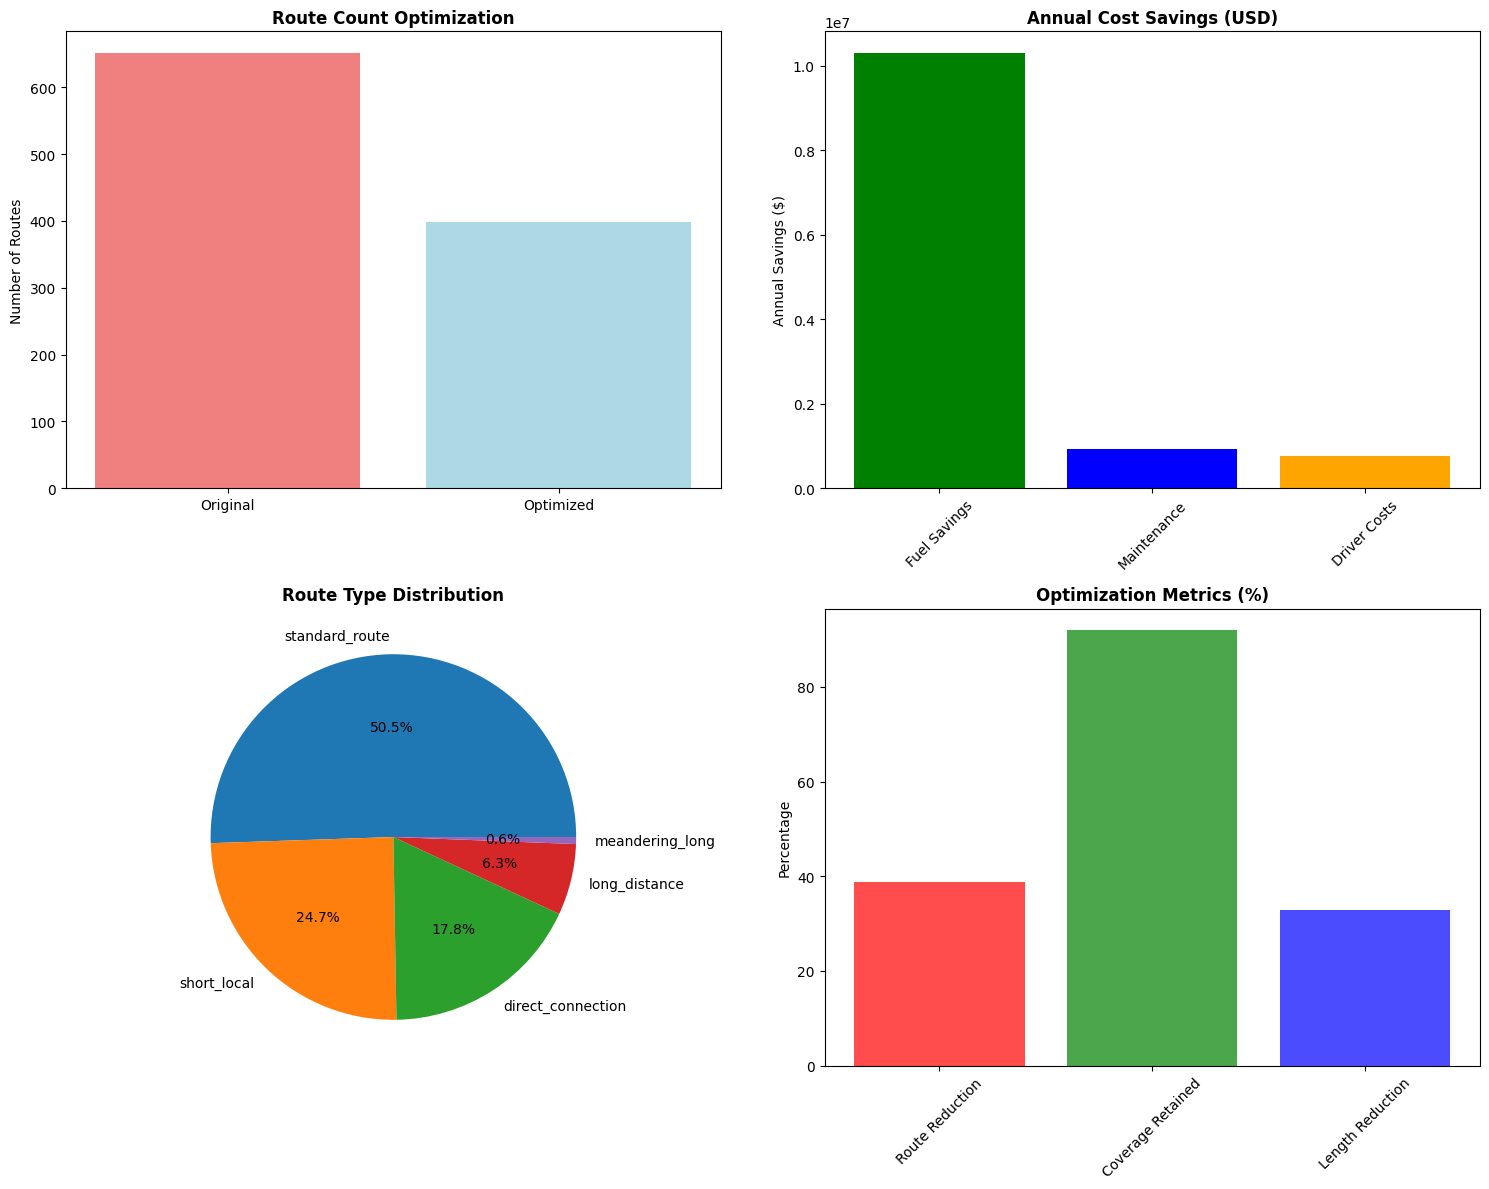


🎉 SUCCESS: Municipal-ready solution achieved!
   Ready for deployment in Accra's transit system

🗺️  Interactive network map:


In [8]:
# =============================================================================
# SECTION 7: MAIN EXECUTION
# =============================================================================

def run_accra_transit_optimization():
    """Execute complete AccraIQ transit optimization analysis"""
    
    print("🚀 Starting AccraIQ Transit Optimization Analysis")
    print("=" * 60)
    
    start_time = time.time()
    
    try:
        # 1. Load and process data
        gtfs_data = load_gtfs_data()
        route_gdf = extract_route_geometries(gtfs_data)
        
        # 2. Compute route similarities
        analyzer = DTWAnalyzer(route_gdf, normalizer=CoordinateNormalizer("utm"))
        distance_matrix = analyzer.compute_similarity_matrix(target_density=5)
        
        # 3. Cluster similar routes
        cluster_labels = cluster_similar_routes(
            distance_matrix, 
            analyzer.valid_route_indices,
            min_cluster_size=5,
            min_samples=5
        )
        
        # 4. Optimize route selection
        selected_routes, coverage_percent, route_count = optimize_route_selection(
            cluster_labels,
            analyzer.valid_route_indices,
            route_gdf,
            gtfs_data,
            coverage_threshold=0.92
        )
        
        # 5. Calculate impact
        impact_calculator = MunicipalImpactCalculator(route_gdf)
        impact = impact_calculator.calculate_impact(
            cluster_labels,
            analyzer.valid_route_indices,
            selected_routes,
            coverage_percent
        )
        
        # 6. Validate solution
        viability = validate_municipal_viability(impact)
        
        # 7. Present results
        elapsed_time = time.time() - start_time
        
        print(f"\n📊 OPTIMIZATION RESULTS")
        print("=" * 60)
        print(f"   Original routes: {impact['total_routes']}")
        print(f"   Optimized routes: {impact['retained_routes']}")
        print(f"   Route reduction: {impact['route_reduction_pct']:.1f}%")
        print(f"   Coverage retained: {impact['coverage_retention_pct']:.1f}%")
        print(f"   Total clusters: {impact['total_clusters']}")
        
        print(f"\n💰 ECONOMIC IMPACT")
        print("=" * 60)
        print(f"   Annual fuel savings: ${impact['annual_fuel_cost_saved_usd']:,.0f}")
        print(f"   Annual maintenance savings: ${impact['annual_maintenance_saved_usd']:,.0f}")
        print(f"   Annual driver savings: ${impact['annual_driver_savings_usd']:,.0f}")
        print(f"   Total annual savings: ${impact['total_annual_savings_usd']:,.0f}")
        print(f"   Vehicle capital freed: ${impact['vehicle_capital_freed_usd']:,.0f}")
        
        print(f"\n🌍 ENVIRONMENTAL IMPACT")
        print("=" * 60)
        print(f"   CO₂ reduction: {impact['annual_co2_saved_tonnes']:.0f} tonnes/year")
        print(f"   Equivalent cars removed: {impact['cars_equivalent_removed']:.0f}")
        
        print(f"\n⏱️  Analysis completed in {elapsed_time / 60:.1f} minutes")
        
        # 8. Create visualizations
        print(f"\n📈 Generating visualizations...")
        
        # Economic visualization
        fig = visualize_optimization_results(impact, route_gdf, selected_routes)
        
        # Interactive map
        interactive_map = create_interactive_map(route_gdf, selected_routes)
        
        return {
            'impact': impact,
            'route_gdf': route_gdf,
            'gtfs_data': gtfs_data,
            'selected_routes': selected_routes,
            'cluster_labels': cluster_labels,
            'viability': viability,
            'interactive_map': interactive_map,
            'analysis_time': elapsed_time
        }
        
    except Exception as e:
        print(f"\n❌ Error in analysis: {e}")
        import traceback
        traceback.print_exc()
        return None

# Execute the optimization
if __name__ == "__main__":
    results = run_accra_transit_optimization()
    
    if results and results['viability']['viable']:
        print(f"\n🎉 SUCCESS: Municipal-ready solution achieved!")
        print(f"   Ready for deployment in Accra's transit system")
        
        # Display the interactive map
        print(f"\n🗺️  Interactive network map:")
        results['interactive_map']
    else:
        print(f"\n📊 Analysis completed with recommendations for refinement")